In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.ndimage
import leggps

import matplotlib.pylab as plt
%matplotlib inline

# interpolation 

### construct a few independent one-d observations

In [2]:
sample1_ts = np.cumsum(npr.exponential(size=1000)+.01) # <-- irregularly spaced observation times!
sample1_vals = sp.ndimage.gaussian_filter1d(npr.randn(1000),10,axis=0)[:,None]

sample2_ts = np.cumsum(npr.exponential(size=100)+.1)
sample2_vals = sp.ndimage.gaussian_filter1d(npr.randn(100),10,axis=0)[:,None]

Note that `sample1_vals` and `sample2_vals` **MUST** be matrices, not vectors:

In [3]:
print(sample1_ts.shape)
print(sample1_vals.shape)
print(sample2_ts.shape)
print(sample2_vals.shape)

(1000,)
(1000, 1)
(100,)
(100, 1)


Look at one of them

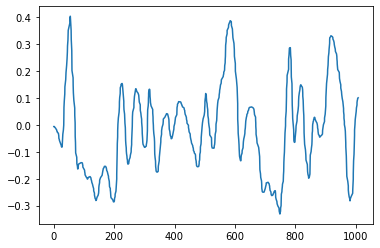

In [4]:
plt.plot(sample1_ts,sample1_vals)

### put them together

In [5]:
all_ts = [sample1_ts,sample2_ts]
all_vals=[sample1_vals,sample2_vals]

### train a model

train a rank-5 LEG model on it

In [6]:
rank=5

In [7]:
result = leggps.training.fit(all_ts,all_vals,rank)

better yet, fit a rank-5 LEG model and get live updates (only works if you have installed tqdm)

In [8]:
# this picks a RANDOM initial condition based on the data
# often works ok
result = leggps.training.fit(all_ts,all_vals,rank,use_tqdm_notebook=True,maxiter=100)

look at the different nats we found as we trained using BFGS.

here `nats = - log likelihood / nobservations`.   lower is better

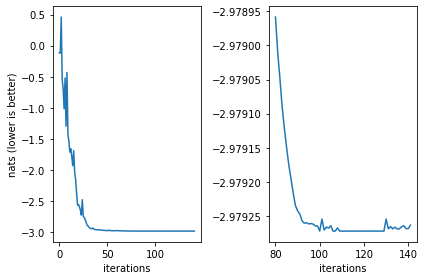

In [9]:
plt.subplot(1,2,1)
iterations=range(len(result['losses']))
plt.plot(iterations,result['losses'])
plt.xlabel('iterations')
plt.ylabel("nats (lower is better)")

plt.subplot(1,2,2)
plt.plot(iterations[80:],result['losses'][80:])
plt.xlabel('iterations')

plt.tight_layout()

Looking at these losses, it seems like maybe we don't need to train anymore.  

In [10]:
print("training result:",result['message'])

training result: Desired error not necessarily achieved due to precision loss.


That means we're as good as we're going to get.  Let's train a little longer, just for fun.

In [11]:
# result['params'] is the model learned in the first round of training
# here we feed it back into the trainer, which uses it as an initial condition...
result2 = leggps.training.fit(all_ts,all_vals,rank,use_tqdm_notebook=True,maxiter=100,**result['params']) 

What did nats look like as we did a second round of training?

Text(0.5, 15.0, 'iterations')

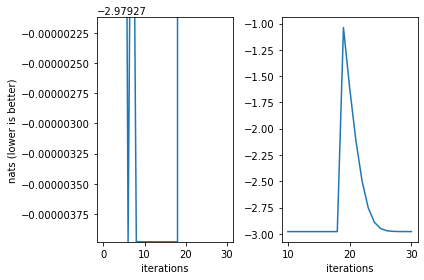

In [16]:
plt.subplot(1,2,1)
iterations=range(len(result2['losses']))
plt.plot(iterations,result2['losses'])
plt.ylim(np.min(result2['losses']),np.min(result['losses']))
plt.xlabel('iterations')
plt.ylabel("nats (lower is better)")

plt.subplot(1,2,2)
plt.plot(iterations[10:],result2['losses'][10:])
plt.tight_layout()
plt.xlabel('iterations')

Looks like at the end we weren't finding any better solutions.  BFGS will always return the best solution that it came across (not necessarily the last one, which may not be the best).

Let's see what the optimizer had to say:

In [17]:
print("training result:",result2['message'])

training result: Desired error not necessarily achieved due to precision loss.


This means we're as good as we're going to get.  Let's look at the model we learned

In [18]:
model = result2['params']

A LEG model has four parameters: N,R,B,Lambda.  We can look at all of them, though they may not mean too much.

In [19]:
print(model['N'])
print(model['R'])
print(model['B'])
print(model['Lambda'])

[[-0.11949157  0.23392343 -0.20374052  0.00319876  0.11311607]
 [ 0.03270123  0.67417592 -0.34294161 -0.61836707  0.30431796]
 [ 0.03780039  0.0593296   0.32928689 -0.54478245  0.00618757]
 [ 0.08316263 -0.36497598 -0.39926842  1.04583135 -0.12259362]
 [ 0.01128091  0.35752002 -0.34198132 -0.25977252  0.11363644]]
[[ 0.          0.00958533 -0.02291785 -0.05134979  0.20785542]
 [-0.00958533  0.          0.11985894 -0.14614048  0.02025517]
 [ 0.02291785 -0.11985894  0.         -0.05879645 -0.17152197]
 [ 0.05134979  0.14614048  0.05879645  0.          0.14648926]
 [-0.20785542 -0.02025517  0.17152197 -0.14648926  0.        ]]
[[-0.08182465  0.0133261  -0.13396916 -0.06562222 -0.01544954]]
[[-0.00601905]]


### forecasting/interpolating

Now that we've trained our model on that dataset, we can do forecasting on any dataset.  Let's make an interesting one.  We'll start by making a regular looking timeseries

In [20]:
sample3_ts = np.cumsum(np.r_[npr.exponential(size=500)])
sample3_vals = sp.ndimage.gaussian_filter1d(npr.randn(500),10,axis=0)[:,None]

But then we'll chop out the middle

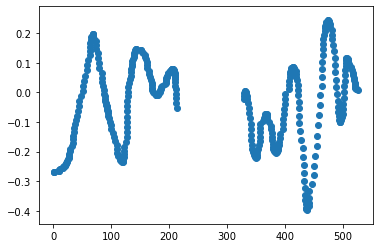

In [21]:
sample3_ts_chopped = np.r_[sample3_ts[:200],sample3_ts[-200:]]
sample3_vals_chopped = np.concatenate([sample3_vals[:200],sample3_vals[-200:]])
plt.scatter(sample3_ts_chopped,sample3_vals_chopped)

Let's see how the model interpolates and forecasts with this data.  We pick a set of times we're interested in.  We feed it the censored observations and the model.  It spits out predictions:

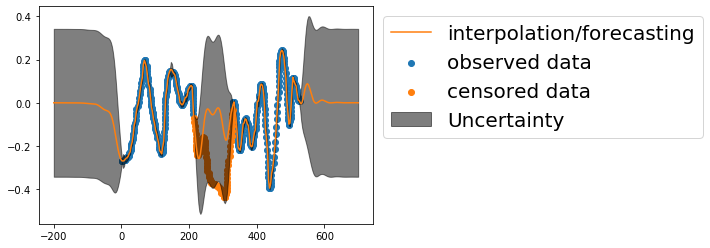

In [22]:
forecast_times=np.r_[-200:700:300j]
means,variances=leggps.posterior_predictive(sample3_ts_chopped,sample3_vals_chopped,forecast_times,**model)
plt.scatter(sample3_ts_chopped,sample3_vals_chopped,label='observed data')
plt.scatter(sample3_ts[200:-200],sample3_vals[200:-200],label='censored data')
plt.plot(forecast_times,means,'C1',label='interpolation/forecasting')
plt.fill_between(forecast_times,
                 means[:,0]+2*np.sqrt(variances[:,0,0]),
                 means[:,0]-2*np.sqrt(variances[:,0,0]),
                color='black',alpha=.5,label='Uncertainty')


plt.legend(bbox_to_anchor=[1,1],fontsize=20)

Let's calculate the likelihood of this data under the model.

In [23]:
leggps.leg_log_likelihood(sample3_ts_chopped,sample3_vals_chopped,**model)

1069.3648010923737

Making sense of this number is a bit difficult.  For fun, we'll take a detour into information theory to look at how we might interpret it.  You can also skip the rest of this section.   

Let's look at the "nats" -- i.e. a measure of how well the model has COMPRESSED the information inside the data.

In [24]:
nobs = np.prod(sample3_vals_chopped.shape)
nats_GP =-leggps.leg_log_likelihood(sample3_ts_chopped,sample3_vals_chopped,**model)/nobs
print("nats =", nats_GP)

nats = -2.673412002730934


We can compare this with the number of nats we would need if we fit the data with a completely independent model:

In [25]:
mu = np.mean(sample3_vals_chopped)
sigmasq = np.var(sample3_vals_chopped)
nats_sillymodel = .5*np.mean((sample3_vals_chopped-mu)**2)/sigmasq + .5*np.log(2*np.pi*sigmasq)
print('nats under independent model = ',nats_sillymodel)

nats under independent model =  -0.5207898773767452


This is a much more positive number, indicating that the compression is worse.  Remember lower is better with nats.

We can take this compression idea to its natural conclusion.  Say we wanted to store this data up to a precision of $\varepsilon = .01$.  Each of these models could be used to design compression algorithms to do this.  When $\varepsilon$ is small relative to the roughness of the density of a model, we can approximate the compression level with an expression like this:

In [26]:
eps=.01
nats_GP_eps= nats_GP - np.log(eps)
nats_sillymodel_eps = nats_sillymodel - np.log(eps)

print("eps=",eps," -- GP has a compression improvement of",nats_sillymodel_eps/nats_GP_eps)

eps= 0.01  -- GP has a compression improvement of 2.114333120993763


If we want to store the data very exactly, this improvement will be less significant.  This is because as we desire more and more exactitude, most of the bits will end up going into encoding the very specific noise variability in each point.  Both models represent the pure noise process with the same efficiency...

In [27]:
eps=.0001
nats_GP_eps= nats_GP - np.log(eps)
nats_sillymodel_eps = nats_sillymodel - np.log(eps)

print("eps=",eps," -- GP has a compression improvement of",nats_sillymodel_eps/nats_GP_eps)

eps= 0.0001  -- GP has a compression improvement of 1.3293017765777861


# smoothing

For smoothing, let's look at datasets which have some noise on top of them.

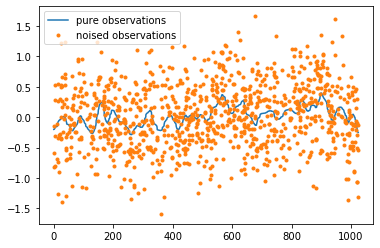

In [3]:
sample1_ts = np.cumsum(npr.exponential(size=1000)+.01)
sample1_vals = sp.ndimage.gaussian_filter1d(npr.randn(1000),10,axis=0)[:,None]
sample1_vals_plusnoise = sample1_vals+.5*npr.randn(1000)[:,None]

plt.plot(sample1_ts,sample1_vals,label='pure observations')
plt.plot(sample1_ts,sample1_vals_plusnoise,'.',label='noised observations')
plt.legend()

In [4]:
rank=5
result = leggps.training.fit([sample1_ts],[sample1_vals_plusnoise],rank,use_tqdm_notebook=True)

Look at training process...

Desired error not necessarily achieved due to precision loss.


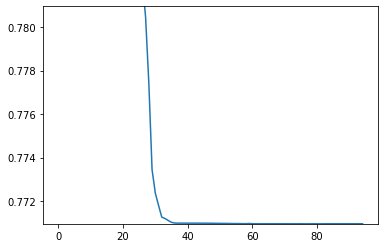

In [5]:
plt.plot(result['losses'])
plt.ylim(np.min(result['losses']),np.min(result['losses'])+.01)
print(result['message'])

Looks fine.  This error about precision loss always happens.  Let's store this model and use it.

In [6]:
model = result['params']

Let's try to smooth the data (in this case, the same data we trained on)

In [7]:
forecast_times=np.r_[-200:600]
means,variances=leggps.posterior_predictive(sample1_ts,sample1_vals_plusnoise,forecast_times,**model)

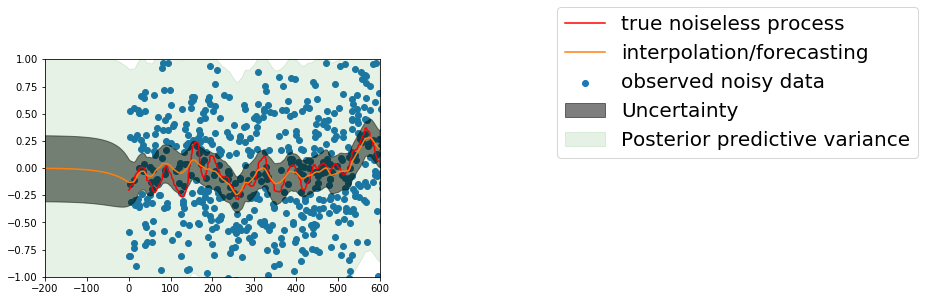

In [8]:
plt.plot(sample1_ts,sample1_vals,'r-',label='true noiseless process')
plt.scatter(sample1_ts,sample1_vals_plusnoise,label='observed noisy data')
plt.plot(forecast_times,means,'C1',label='interpolation/forecasting')
plt.fill_between(forecast_times,
                 means[:,0]+2*np.sqrt(variances[:,0,0]),
                 means[:,0]-2*np.sqrt(variances[:,0,0]),
                color='black',alpha=.5,label='Uncertainty')


v2 = variances + model['Lambda']@model['Lambda'].T
plt.fill_between(forecast_times,
                 means[:,0]+2*np.sqrt(v2[:,0,0]),
                 means[:,0]-2*np.sqrt(v2[:,0,0]),
                color='green',alpha=.1,label='Posterior predictive variance')

plt.xlim(-200,600)
plt.ylim(-1,1)

plt.legend(bbox_to_anchor=[1.5,.5],fontsize=20)

This shows the difference between the posterior predictive uncertainty and the posterior predictive variances.  T

- The posterior predictive uncertainty (gray) tells us how uncertain we are about the true noiseless process
- The posterior predictive variances (green) tells us how uncertain we should be about the value of a new observation at a particular time.  

To understand how the model works, it can be interesting to look at the latent PEG process which drives our LEG model.  This gives us a representation of the complete "state" of the system at each moment.

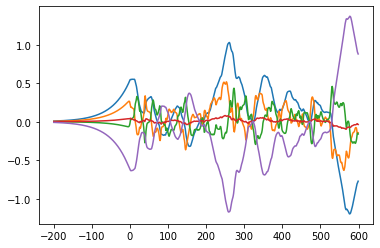

In [9]:
means,variances=leggps.posterior(sample1_ts,sample1_vals_plusnoise,forecast_times,**model)
plt.plot(forecast_times,means)

Each color in the plot above corresponds to a different latent dimension.  

Another way to think about the learned model is to look directly at the LEG covariance.  

In [23]:
taus=np.r_[0:400]
C_PEG=leggps.C_PEG(taus,**model)
C_LEG=leggps.C_LEG(taus,**model)

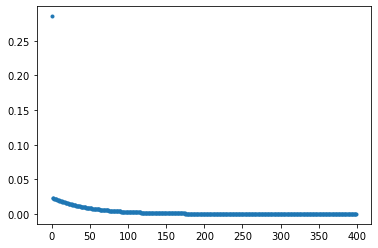

In [24]:
plt.plot(taus,C_LEG[:,0,0],'.')

Here we see that the marginal variance ($C(0)$) is much higher than $C(\tau),\tau>0$.  That's because of the observation noise.  

To see what the learned covariance looks like from another perspective, we can zoom in:

(0, 0.022927325528571282)

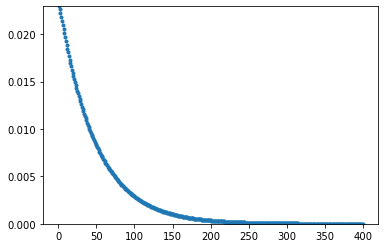

In [25]:
plt.plot(taus,C_LEG[:,0,0],'.')
plt.ylim(0,C_LEG[1,0,0])